In [118]:
import sys
sys.path.append('../')

from models import Seed, engine, Base, Team, Match, MatchPredictions

from scipy.stats import norm

from sqlalchemy.orm import sessionmaker
from sqlalchemy import *

Session = sessionmaker(bind=engine)

session = Session()

session.query(Team)

session.query(Seed.Seed).filter(Seed.Season == 2003).filter(Seed.TeamID==1272).all()

import pandas as pd

dancers = pd.DataFrame(session.query(Seed.TeamID, Seed.Seed.label('seed')).filter(Seed.Season==2018).all())

dancers_df = dancers.sort_values(by='TeamID').set_index('TeamID', drop = True)

def get_most_recent_stats(Season):
    Session = sessionmaker(bind=engine)
    session = Session()

    q = session.query(Team.TeamID, func.max(Match.mdid).label('mdid')).join(
    Match.teams).filter(Match.Season == Season).group_by(Team.TeamID).subquery()

    winners = list(session.query(Match.WTeamID, Match.WFGP3_avg, Match.WFGP_avg, Match.WR_avg, MatchPredictions.WTeamRatingAfter).join(
    q, and_(Match.WTeamID==q.c.TeamID, Match.mdid == q.c.mdid)
                                                                       ).join(MatchPredictions).all())

    losers = list(session.query(Match.LTeamID, Match.LFGP3_avg, Match.LFGP_avg, Match.LR_avg, MatchPredictions.LTeamRatingAfter).join(
    q, and_(Match.LTeamID==q.c.TeamID, Match.mdid == q.c.mdid)
                                                                       ).join(MatchPredictions).all())

    all_stats = winners + losers
    
    df = pd.DataFrame(all_stats, columns = ['TeamID', 'FGP3', 'FGP', 'R','rating'])
    df.set_index('TeamID', inplace = True, drop = True)

    return df

dancer_to_stats = get_most_recent_stats(2018)

full_df = dancers_df.merge(dancer_to_stats, left_index = True, right_index = True)

dancers_dicts = full_df.to_dict(orient='index')

dsts = list(dancer_to_stats.index)



x = list(dancers.TeamID)

x.sort()

matchups = []
for z in x:
    for y in x:
        if y < z:
            matchups.append((y,z))

from elo_run.link import predict
from elo_run.link_functions import *
from elo_run.response_function import home_response, away_response, neutral_response
from elo_run.run_model import run_model_one_season
from elo_run.set_up_elo import ELO
from elo_run.update_rating import update_function

response_fns = {
    'H': home_response,
    'A': away_response,
    'N': neutral_response
}

predictions = []
model_params = {
    'rating': 1,
    'seed': 0,
    'FGP': 0,
    'R': 0,
    'FGP3': 0,
    'standard_devation': 600,
    'link': normal_link
}

elo = ELO(link_function=predict,
         response_functions = response_fns,
         update_function = update_function,
         model_params=model_params,
         K=40)

for team_1, team_2 in matchups:
    team_1_stats = dancers_dicts[team_1]
    team_2_stats = dancers_dicts[team_2]
    prediction = elo.predict(team_1_stats, team_2_stats)
    
    predictions.append((session.query(Team.TeamName).filter(Team.TeamID==team_1).first(),
                        session.query(Team.TeamName).filter(Team.TeamID==team_2).first()
                        , prediction))
    
prediction_df = pd.DataFrame(predictions, columns = ['team_1', 'team_2', 'Pred'])

pd.set_option('display.max_rows',3000)

prediction_df.to_csv('../hello_me.csv')

prediction_df.team_1 = prediction_df.team_1.astype(str)

prediction_df.team_2 = prediction_df.team_2.astype(str)

prediction_df['teams'] = prediction_df.team_1.apply(lambda x: x[2:5]) + prediction_df.team_2.apply(lambda x: x[2:5])

prediction_df.to_csv('../easysearch.csv')

In [119]:
from models import Seed, engine, Base, Team, Match, MatchPredictions

In [120]:
from scipy.stats import norm

In [122]:
from sqlalchemy.orm import sessionmaker
from sqlalchemy import *

In [123]:
Session = sessionmaker(bind=engine)

In [124]:
session = Session()

In [125]:
session.query(Team)

In [126]:
session.query(Seed.Seed).filter(Seed.Season == 2003).filter(Seed.TeamID==1272).all()

[(7)]

In [127]:
import pandas as pd

In [128]:
dancers = pd.DataFrame(session.query(Seed.TeamID, Seed.Seed.label('seed')).filter(Seed.Season==2018).all())

In [129]:
dancers_df = dancers.sort_values(by='TeamID').set_index('TeamID', drop = True)

In [130]:
def get_most_recent_stats(Season):
    Session = sessionmaker(bind=engine)
    session = Session()

    q = session.query(Team.TeamID, func.max(Match.mdid).label('mdid')).join(
    Match.teams).filter(Match.Season == Season).group_by(Team.TeamID).subquery()

    winners = list(session.query(Match.WTeamID, Match.WFGP3_avg, Match.WFGP_avg, Match.WR_avg, MatchPredictions.WTeamRatingAfter).join(
    q, and_(Match.WTeamID==q.c.TeamID, Match.mdid == q.c.mdid)
                                                                       ).join(MatchPredictions).all())

    losers = list(session.query(Match.LTeamID, Match.LFGP3_avg, Match.LFGP_avg, Match.LR_avg, MatchPredictions.LTeamRatingAfter).join(
    q, and_(Match.LTeamID==q.c.TeamID, Match.mdid == q.c.mdid)
                                                                       ).join(MatchPredictions).all())

    all_stats = winners + losers
    
    df = pd.DataFrame(all_stats, columns = ['TeamID', 'FGP3', 'FGP', 'R','rating'])
    df.set_index('TeamID', inplace = True, drop = True)

    return df

In [131]:
dancer_to_stats = get_most_recent_stats(2018)

In [132]:
full_df = dancers_df.merge(dancer_to_stats, left_index = True, right_index = True)

In [133]:
dancers_dicts = full_df.to_dict(orient='index')

In [134]:
dsts = list(dancer_to_stats.index)

In [136]:
x = list(dancers.TeamID)

In [137]:
x.sort()

In [138]:
matchups = []
for z in x:
    for y in x:
        if y < z:
            matchups.append((y,z))

In [139]:
from elo_run.link import predict
from elo_run.link_functions import *
from elo_run.response_function import home_response, away_response, neutral_response
from elo_run.run_model import run_model_one_season
from elo_run.set_up_elo import ELO
from elo_run.update_rating import update_function

response_fns = {
    'H': home_response,
    'A': away_response,
    'N': neutral_response
}

In [141]:
predictions = []
model_params = {
    'rating': 1,
    'seed': 0,
    'FGP': 0,
    'R': 0,
    'FGP3': 0,
    'standard_devation': 600,
    'link': normal_link
}

elo = ELO(link_function=predict,
         response_functions = response_fns,
         update_function = update_function,
         model_params=model_params,
         K=40)

for team_1, team_2 in matchups:
    team_1_stats = dancers_dicts[team_1]
    team_2_stats = dancers_dicts[team_2]
    prediction = elo.predict(team_1_stats, team_2_stats)
    
    predictions.append((session.query(Team.TeamName).filter(Team.TeamID==team_1).first(),
                        session.query(Team.TeamName).filter(Team.TeamID==team_2).first()
                        , prediction))
    
prediction_df = pd.DataFrame(predictions, columns = ['team_1', 'team_2', 'Pred'])

In [143]:
pd.set_option('display.max_rows',3000)

In [145]:
prediction_df.to_csv('../hello_me.csv')

In [147]:
prediction_df.team_1 = prediction_df.team_1.astype(str)

In [148]:
prediction_df.team_2 = prediction_df.team_2.astype(str)

In [149]:
prediction_df['teams'] = prediction_df.team_1.apply(lambda x: x[2:5]) + prediction_df.team_2.apply(lambda x: x[2:5])

In [151]:
prediction_df.to_csv('../easysearch.csv')

In [93]:
import  matplotlib.pyplot as plt

(array([  1.,   2.,   2.,   1.,   0.,   4.,   3.,   3.,   2.,   7.,   6.,
          4.,   8.,   7.,   3.,  12.,   8.,  20.,  19.,  19.,  17.,  17.,
         16.,  22.,  33.,  25.,  24.,  20.,  26.,  24.,  22.,  29.,  29.,
         21.,  40.,  26.,  28.,  33.,  26.,  46.,  36.,  35.,  50.,  37.,
         40.,  47.,  54.,  53.,  51.,  49.,  50.,  46.,  54.,  39.,  47.,
         46.,  41.,  39.,  38.,  55.,  27.,  32.,  29.,  33.,  26.,  40.,
         25.,  26.,  35.,  35.,  31.,  22.,  26.,  27.,  29.,  26.,  24.,
         27.,  16.,  18.,  27.,  21.,  10.,  14.,  19.,   7.,   4.,   4.,
         10.,   6.,   5.,   9.,   3.,   5.,   3.,   0.,   7.,   5.,   0.,
          3.]),
 array([ 0.07626742,  0.08449315,  0.09271887,  0.10094459,  0.10917032,
         0.11739604,  0.12562177,  0.13384749,  0.14207322,  0.15029894,
         0.15852466,  0.16675039,  0.17497611,  0.18320184,  0.19142756,
         0.19965329,  0.20787901,  0.21610473,  0.22433046,  0.23255618,
         0.24078191,  0.24

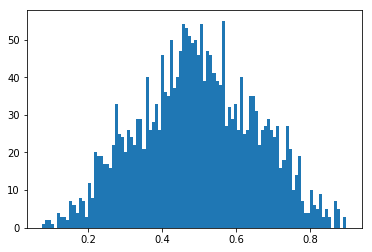

In [94]:
plt.hist(prediction_df.Pred, bins = 100)

In [ ]:
dancers_dicts

In [135]:
dsts.sort()
dsts

[1101,
 1102,
 1103,
 1104,
 1105,
 1106,
 1107,
 1108,
 1110,
 1111,
 1112,
 1113,
 1114,
 1115,
 1116,
 1117,
 1119,
 1120,
 1122,
 1123,
 1124,
 1125,
 1126,
 1127,
 1129,
 1130,
 1131,
 1132,
 1133,
 1135,
 1136,
 1137,
 1138,
 1139,
 1140,
 1141,
 1142,
 1143,
 1144,
 1145,
 1146,
 1148,
 1149,
 1150,
 1151,
 1152,
 1153,
 1154,
 1155,
 1156,
 1157,
 1158,
 1159,
 1160,
 1161,
 1162,
 1163,
 1164,
 1165,
 1166,
 1167,
 1168,
 1169,
 1170,
 1171,
 1172,
 1173,
 1174,
 1175,
 1176,
 1177,
 1178,
 1179,
 1180,
 1181,
 1182,
 1183,
 1184,
 1185,
 1186,
 1187,
 1188,
 1189,
 1190,
 1191,
 1192,
 1193,
 1194,
 1195,
 1196,
 1197,
 1198,
 1199,
 1200,
 1201,
 1202,
 1203,
 1204,
 1205,
 1206,
 1207,
 1208,
 1209,
 1210,
 1211,
 1212,
 1213,
 1214,
 1216,
 1217,
 1218,
 1219,
 1220,
 1221,
 1222,
 1223,
 1224,
 1225,
 1226,
 1227,
 1228,
 1229,
 1230,
 1231,
 1232,
 1233,
 1234,
 1235,
 1236,
 1237,
 1238,
 1239,
 1240,
 1241,
 1242,
 1243,
 1244,
 1245,
 1246,
 1247,
 1248,
 1249,
 1250,